# Corporación Favorita Grocery Sales Forecasting
#### Practical Deep Learning Workshop 2021- Category embeddings
Inbal Biton, Shachar Meretz

Team name in Kaggle : BGU-DL INBAL SHACHAR 2021






For this assigment we use kaggle dataeset - Corporación Favorita Grocery Sales Forecasting 

(https://www.kaggle.com/c/favorita-grocery-sales-forecasting/submit)

In this task we received a dataset containing information on buying products in stores in Ecuador by the date of purchase.
In this task we predicted to a certain date the quantity of products they would buy in a certain store. For this purpose we will use regression models.

Our training data are all days of the year from 2013 to 2016 plus January to mid-August 2017. Our test data will be the last two weeks of August.

In addition, this task provides additional information about the stores, the types of products, special dates, events that have taken place in Ecuador over the years and even changes in fuel prices.

During this assignment we will use the many tools we have learned about category embedding and in addition we will try to use the time variables to see if they can give us more information about shopping for products in stores.

# Imports and Functions
These functions upload the data to the system. While uploading the data we encountered a memory problem which does not allow us to fully upload all the data to the system. 

As a result we decided to use only some of the given data in an attempt to predict in the most accurate way.

We tried to think about what information is important to us in order to predict the last two weeks of August in 2017. We assumed that the important information is in the period before these two weeks cause the last time affects the amount of shopping of the current time, and we assumed that it is important to know what usually happens during these weeks. (Because there may be special holidays or great freedom).

We debated between 3 dataset:

1.First dataset which containing the entire month of August throughout the years (2013-2016) and the first two weeks of August in 2017.

2.Second dataset which containing all the last two weeks of August throughout the years (2013-2016).

3.Third dataset which containing the months of May to July, and the first two weeks of August from 2017.

The purpose of the above datasets is to be the most accurate for the purpose of predicting the last two weeks of August in 2017

In addition, during the uploading we realized that all values given can be reduced to a very small amount of bits in order to reduce the amount of memory we use.

For this operation we used the function "reduce_mem_usage".


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Model , model_from_json
from tensorflow.keras.layers import Input, Embedding, dot, Dot, add,Flatten, concatenate,Dropout, Dense
from tensorflow.keras.callbacks import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical

from sklearn import preprocessing, metrics
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
import lightgbm as lgb

import gc; gc.enable()
import random
import timeit
import matplotlib.image as mpimg

np.random.seed(100)

#path=r"C:\Users\shachar meretz\Desktop\semestr7\assigment2"
path=r"/content/drive/MyDrive/grocery"

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
from tqdm import tqdm

def reduce_mem_usage(df):
  start_mem=df.memory_usage().sum() / 1024**2

  for col in (df.columns) :
    col_type=df[col].dtype
    if col_type != object and col_type.name!='category' and 'datetime' not in col_type.name:
      c_min= df[col].min()
      c_max= df[col].max()
      if str(col_type)[:3] == 'int':

        if c_min> np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
          df[col]=df[col].astype(np.int8)
        elif c_min> np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
          df[col]=df[col].astype(np.int16)
        elif c_min> np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
          df[col]=df[col].astype(np.int32)
        elif c_min> np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
          df[col]=df[col].astype(np.int64)
        
      else:
        if c_min> np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
          df[col]=df[col].astype(np.float16)
        elif c_min> np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
          df[col]=df[col].astype(np.float32)
        else:
          df[col]=df[col].astype(np.float64)
      
    elif 'datatime' not in col_type.name:
      df[col]= df[col].astype('category')
    
  end_mem=df.memory_usage().sum()/1024**2
  print('Decreased by {:.1f}%'.format(100*(start_mem-end_mem)/start_mem))
  return df 

In [17]:
def upload_data(which_data):
  datatypes = {'id':'int64', 'item_nbr':'int32', 'store_nbr':'int8', 'onpromotion':str}

  data_test=pd.read_csv(path+'//test.csv', dtype=datatypes, parse_dates=['date'])
  data_test=reduce_mem_usage(data_test)

  data_train=pd.read_csv(path+'//train.csv', dtype=datatypes, parse_dates=['date'])#,skiprows = [i for i in range(1, 125497000)])
  data_train=reduce_mem_usage(data_train) 

  if which_data==1:
    data_train2 = data_train[(data_train['date'].dt.month == 8) & (data_train['date'].dt.day > 15)]
  elif which_data==2:
    data_train2 = data_train[(data_train['date'].dt.year == 2017) & (data_train['date'].dt.month > 5)]
  else:
    data_train2 = data_train[(data_train['date'].dt.month == 8)]

  del data_train; gc.collect();
  data_train=data_train2
  del data_train2; gc.collect();
  data_train=reduce_mem_usage(data_train) 

  data_items=pd.read_csv(path+'//items.csv')
  data_items=reduce_mem_usage(data_items)
  n_items=data_items.shape[0]

  data_stores=pd.read_csv(path+'//stores.csv')
  data_stores=reduce_mem_usage(data_stores)
  n_stores=data_stores.shape[0]

  data_oil=pd.read_csv(path+'//oil.csv')
  data_oil=reduce_mem_usage(data_oil)

  holiday=pd.read_csv(path+'//holidays_events.csv')
  holiday=reduce_mem_usage(holiday)

  train=data_train
  del data_train; gc.collect();
  return train,data_test,data_items,data_stores,data_oil,holiday,n_items,n_stores


In [18]:
import os

def save_model(model,filename):
    # this is a helper function used to save a keras NN model architecture and weights
    json_string = model.to_json()
    open(os.path.join(path+"/", filename+'_architecture.json'), 'w').write(json_string)
    model.save_weights(os.path.join(path+"/", filename+'_model_weights.h5'), overwrite=True)
    
def read_model(filename):
    # this is a helper function used to restore a keras NN model architecture and weights
    model = model_from_json(open(os.path.join(path+'/e_bias_model/', filename+'_architecture.json')).read())
    model.load_weights(os.path.join(path+'/e_bias_model/', filename+'_model_weights.h5')) ##best_model_weights_run1
    return model


# Graphs

Several graphs are displayed to represent the data (things that can be interesting during a feature search):

**The first graph** represents the average sales in each store.

It can be seen that the graph is not uniform so we can conclude that store related features like cluster, city, state would be important as they knew how to differentiate well.

**The second graph** represents average sales each year.
As can be seen the sales average is relatively evenly divided. In this way we can conclude that we may not have meaning for change in years but only in days.

**The third graph** represents our average sales each day of the week.
Before we look at the graph we can conclude that there are differences between the days of the week (there is not the same amount of shopping on Monday versus Thursday).
After looking at the graph it seems that our thinking is correct, and we will conclude that day of week can be a significant feature for this dataset.

Finally, a table is attached that shows us the stores with the products that bought the most so that we have a specific understnding on our data.

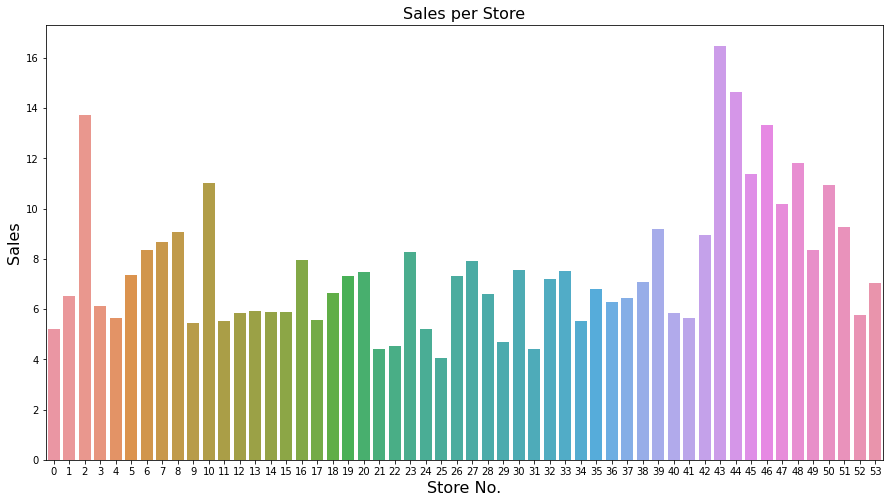

In [21]:
import seaborn as sns
x=train.groupby(['store_nbr'],as_index=False).agg({'unit_sales':'mean'})

fig,ax=plt.subplots()
fig.set_size_inches(15,8)
ax=sns.barplot(x=x.index, y="unit_sales", data=x)
plt.title("Sales per Store", fontsize=16)
plt.ylabel('Sales',fontsize=16)
plt.xlabel('Store No.',fontsize=16)
plt.show()


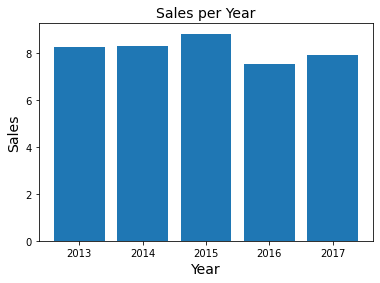

In [29]:
x=train.groupby(['yea'],as_index=False).agg({'unit_sales':'mean'})

plt.bar(x.yea, x.unit_sales)
plt.title('Sales per Year', fontsize=14)
plt.ylabel('Sales',fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.show()


Text(0, 0.5, 'Sales')

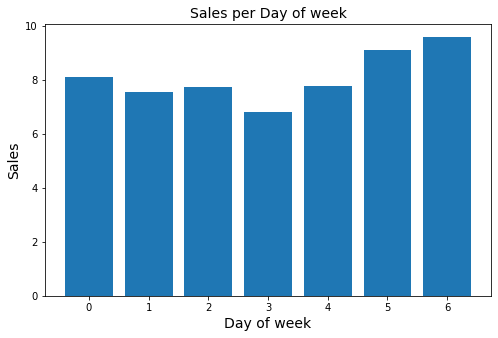

In [31]:
x=train.groupby(['dayofweek'],as_index=False).agg({'unit_sales':'mean'})

plt.figure(figsize=(8,5))
plt.bar(x.dayofweek,x.unit_sales)
plt.title('Sales per Day of week',fontsize=14)
plt.xlabel('Day of week', fontsize=14)
plt.ylabel('Sales', fontsize=14)

In [ ]:

Best_selling_products = train_temp['item_nbr'].value_counts().index[:10].values 
Best_selling_stores = train_temp['store_nbr'].value_counts().index[:10].values 
data_temp=train_temp
data_temp
top_data = data_temp.loc[(data_temp['item_nbr'].isin(Best_selling_products))&(data_temp['store_nbr'].isin(Best_selling_stores)),:]

top_data
pd.crosstab(columns=top_data['item_nbr'],index=top_data['store_nbr'],values=top_data['unit_sales'],aggfunc=sum).fillna(value='')


item_nbr,265559,314384,364606,502331,559870,564533,587069,1036689,1146795,1157564
store_nbr,,,,,,,,,,
3,4984.0,6248.0,6748.0,4776.0,2512.0,2632.0,1226.0,3624.0,3020.0,2200.0
6,3984.0,3476.0,3904.0,2658.0,2872.0,1978.0,1012.0,1844.0,1323.0,1097.0
8,2824.0,3436.0,3944.0,2812.0,1468.0,1830.0,697.0,1649.0,2202.0,1130.0
44,7016.0,6644.0,7212.0,5696.0,4808.0,2578.0,1427.0,5676.0,4584.0,2352.0
45,8064.0,8816.0,7860.0,4248.0,6036.0,4600.0,1558.0,4576.0,3184.0,2844.0
46,8056.0,6688.0,6796.0,4404.0,6376.0,3768.0,2033.0,3398.0,2064.0,2458.0
47,7980.0,6836.0,7124.0,5056.0,6424.0,2980.0,1794.0,4152.0,2608.0,2236.0
48,7528.0,4924.0,5184.0,4516.0,6544.0,4760.0,1670.0,2638.0,1542.0,2033.0
49,3006.0,4416.0,4712.0,3666.0,2408.0,2514.0,614.0,3256.0,2204.0,1216.0


# Pre process the dataset

After going over the dataset, we started preparing it for our mission.

By using the function below we got information about the diffrents tables and saw in which columns there are missing values that need to be filled.

We filled the missing values ( by default parameters) - for oil table in dcoilwtico column we put -1 for the oil price and for train table in onpromotion column we put false for the nan values.

Moreover, we merged 2 tables to get all the information needed for the initial training, changed the product values using the encoder function, seperate the date from datatime to year,month and day and replace the value in items table in perishable column from 0 and 1 that respresnt if the product can go bad to 1 and 1.25 that represnt the weights for the NWRMSLE function.

Next, we split our data into a training set and a validation set for the training where the solid benchmark was set.

In [ ]:
 train,test,items,stores,oil,holiday,n_items,n_stores=upload_data(3)

In [ ]:
def find_nan(df,name):
  print(name)
  if df.isnull().values.any():
    null_columns=df.columns[df.isnull().any()].tolist()
    for column in null_columns:
      total_values=df.shape[0]
      null_values=df[column].isnull().sum()
      print("No. of Nan Values in '{}' column --> {}".format(column,null_values))
      print("{:.2f} % of Total values".format((100*null_values)/total_values))
  else:
    print("No Column has Nan Values")

find_nan(train,"train:")
find_nan(test,"test:")
find_nan(items,"items:")
find_nan(stores,"stores:")
find_nan(oil,"oil:")
find_nan(holiday,"holiday:")


train:
No. of Nan Values in 'onpromotion' column --> 733280
16.44 % of Total values
test:
No Column has Nan Values
items:
No Column has Nan Values
stores:
No Column has Nan Values
oil:
No. of Nan Values in 'dcoilwtico' column --> 43
3.53 % of Total values
holiday:
No Column has Nan Values


In [ ]:
import datetime as dt

def label_encoding(df):
    for c in df.columns:
        if df[c].dtype == 'object':
            lbl = preprocessing.LabelEncoder()
            df[c] = lbl.fit_transform(df[c])
            print(c)
    return df

def transform_dataframe(df):
    df['onpromotion'] = df['onpromotion'].map({'False': 0, 'True': 1})
    df['perishable'] = df['perishable'].map({0:1.0, 1:1.25})
    df['date'] = pd.to_datetime(df['date'])
    df['yea'] = df['date'].dt.year
    df['mon'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    return df


data_items= label_encoding(items)

train = pd.merge(train, items, how='left', on=['item_nbr'])
train=reduce_mem_usage(train)

test = pd.merge(test, items, how='left', on=['item_nbr'])
test=reduce_mem_usage(test)

del items; gc.collect();

train = transform_dataframe(train)
train=reduce_mem_usage(train)

test = transform_dataframe(test)
test=reduce_mem_usage(test)

target=train['unit_sales'].values
target[target<0.]=0.
train['unit_sales']=np.log2(target+1)

train['onpromotion']=train['onpromotion'].astype(float)
train['onpromotion']=train['onpromotion'].fillna(np.int(-1))
train=reduce_mem_usage(train)


train_temp = train[['yea','mon','day','store_nbr', 'item_nbr', 'unit_sales', 'perishable']].copy()
del train; gc.collect();



In [ ]:
train_temp.head()

,yea,mon,day,store_nbr,item_nbr,unit_sales,perishable
0,2013,8,1,1,96995,1.584961,1.00
1,2013,8,1,1,103520,1.000000,1.00
2,2013,8,1,1,103665,2.000000,1.25
3,2013,8,1,1,105574,3.322266,1.00
4,2013,8,1,1,105575,4.000000,1.00


In [ ]:

train_col=['yea','mon','day','store_nbr','item_nbr','perishable']
features = ['yea','mon','day','store_nbr','item_nbr']

labels=train_temp[['unit_sales']].copy()
x_train, x_val , y_train , y_val=train_test_split(train_temp[train_col],labels,test_size=0.2)

train_col=x_train[['yea','mon','day','store_nbr','item_nbr']].copy()
train_weights=x_train[['perishable']].copy()

val_col=x_val[['yea','mon','day','store_nbr','item_nbr']].copy()
val_weights=x_val[['perishable']].copy()

# Classical ML algorithm



We will now select a model of machine learning that performs prediction using regression.In these models we will train the training set and the validation set, and we will check the test set values.

In this training we will use the 3 DATASETS we discussed earlier and in addition we will use 2 machine learning models to show that the result is indeed good and represents our solid benchmark.

The 2 machine learning models we have chosen are:

1. random forest regressor

2. XGB regressor


Each of the models we will calculate the accuracy of the prediction on the training set and the validation set. 

In addition we will present the values we received from Kaggle for each of the models for each of the possible datasets.

In [ ]:
from sklearn.model_selection import KFold,StratifiedKFold

def NWRMSLE(y, pred, w=None):
    return metrics.mean_squared_error(y, pred,sample_weight=w)**0.5 

################RandomForestRegressor##################

xg_reg = RandomForestRegressor(n_estimators=5, max_depth = 3, n_jobs = -1, criterion='mse')
start = timeit.default_timer()
xg_reg.fit(train_col,y_train)
stop = timeit.default_timer()
fit_time_train_rfr = stop - start

start = timeit.default_timer()
pred_val_train=xg_reg.predict(train_col)
stop = timeit.default_timer()
predict_time_train_rfr = stop - start

start = timeit.default_timer()
pred_val_test=xg_reg.predict(val_col)
stop = timeit.default_timer()
predict_time_test_rfr = stop - start

rmse_val_train_rfr=metrics.mean_squared_error(y_train, pred_val_train)**0.5
NWRMSLE_val_train_rfr=NWRMSLE(y_train,pred_val_train, train_weights)

rmse_val_test_rfr=metrics.mean_squared_error(y_val, pred_val_test)**0.5
NWRMSLE_val_test_rfr=NWRMSLE(y_val,pred_val_test,val_weights)

print(rmse_val_train_rfr)
print(NWRMSLE_val_train_rfr)
print(rmse_val_test_rfr)
print(NWRMSLE_val_test_rfr)

test_kaggle=test[['yea','mon','day','store_nbr','item_nbr']].copy()
pred_val_kaggle=xg_reg.predict(test_kaggle)

################XGBRegressor##################

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)
start = timeit.default_timer()
train_col=train_col[['yea','mon','day','store_nbr','item_nbr']].copy()
xg_reg.fit(train_col,y_train)
stop = timeit.default_timer()
fit_time_train_xgb = stop - start

start = timeit.default_timer()
pred_val_train=xg_reg.predict(train_col)
stop = timeit.default_timer()
predict_time_train_xgb = stop - start

val_col=val_col[['yea','mon','day','store_nbr','item_nbr']].copy()
start = timeit.default_timer()
pred_val_test=xg_reg.predict(val_col)
stop = timeit.default_timer()
predict_time_test_xgb = stop - start

rmse_val_train_xgb=metrics.mean_squared_error(y_train, pred_val_train)**0.5
NWRMSLE_val_train_xgb=NWRMSLE(y_train,pred_val_train, train_weights)

rmse_val_test_xgb=metrics.mean_squared_error(y_val, pred_val_test)**0.5
NWRMSLE_val_test_xgb=NWRMSLE(y_val,pred_val_test,val_weights)

pred_val_kaggle2=xg_reg.predict(test_kaggle)



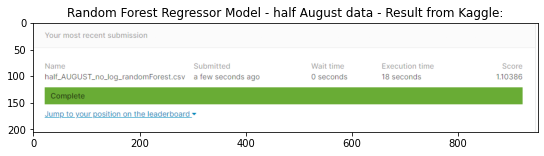

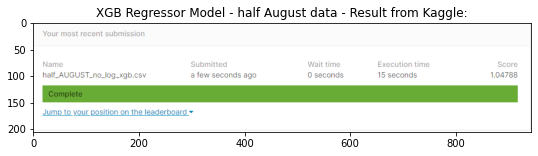

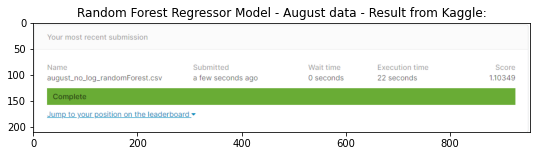

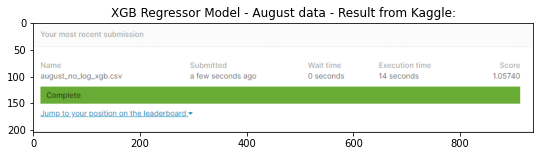

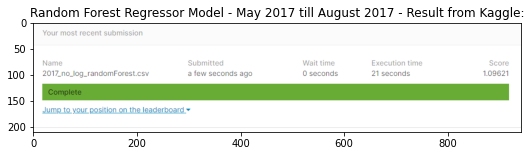

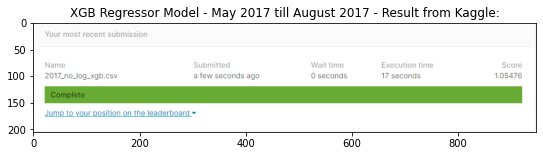

In [3]:

plt.figure(figsize = (20,2))
plt.title("Random Forest Regressor Model - half August data - Result from Kaggle:")
plt.imshow(mpimg.imread(path+'/picKaggle/4.PNG'))

plt.figure(figsize = (20,2))
plt.title("XGB Regressor Model - half August data - Result from Kaggle:")
plt.imshow(mpimg.imread(path+'/picKaggle/2.PNG'))

plt.figure(figsize = (20,2))
plt.title("Random Forest Regressor Model - August data - Result from Kaggle:")
plt.imshow(mpimg.imread(path+'/picKaggle/9.PNG'))

plt.figure(figsize = (20,2))
plt.title("XGB Regressor Model - August data - Result from Kaggle:")
plt.imshow(mpimg.imread(path+'/picKaggle/11.PNG'))

plt.figure(figsize = (20,2))
plt.title("Random Forest Regressor Model - May 2017 till August 2017 - Result from Kaggle:")
plt.imshow(mpimg.imread(path+'/picKaggle/5.PNG'))

plt.figure(figsize = (20,2))
plt.title("XGB Regressor Model - May 2017 till August 2017 - Result from Kaggle:")
plt.imshow(mpimg.imread(path+'/picKaggle/7.PNG'))


As you can see the three diffrent datasets give us about the same values
(1.04-1.05 for XGB Regressor and 1.09-1.10 for Random Forest Regressor).
In addition, XGB appears to have a slightly lower LOSS value than RFG.

As a result, we set our **solid benchmark as 1.05** in KAGGLE and chose our dataset to be dataset number 1 (contains the entire month of August throughout the years (2013-2016) and the first two weeks of August in 2017.)

In addition, we will present in the table below the time it takes for these 2 models to train the desired data and what are the RMSE and NWRMSLE values ​​we received for the training set and the validation set.

Remember that even if we get low values ​​in the loss value of the training set and validation set it does not mean that it will indeed correctly predict the last two weeks of August in 2017 so our solid benchmark value is based on the value we got from Kaggle for our test set

In [ ]:
summariz_df = pd.DataFrame(columns=[ '' , 'XGB Regressor Model' , 'Random Forest Regressor Model'])
summariz_df[''] = ['Fit Time Sec' , 'Prediction Time Sec train' ,'Prediction Time Sec test'
,'rmse val train' , 'nwrmsle val train' ,'rmse val test' , 'nwrmsle val test' ]
summariz_df.set_index('' , inplace=True)

summariz_df.loc['Fit Time Sec' , 'XGB Regressor Model'] = fit_time_train_xgb
summariz_df.loc['Prediction Time Sec train' , 'XGB Regressor Model'] = predict_time_train_xgb
summariz_df.loc['Prediction Time Sec test' , 'XGB Regressor Model'] = predict_time_test_xgb
summariz_df.loc['rmse val train' , 'XGB Regressor Model'] = rmse_val_train_xgb
summariz_df.loc['nwrmsle val train' , 'XGB Regressor Model'] = NWRMSLE_val_train_xgb
summariz_df.loc['rmse val test' , 'XGB Regressor Model'] = rmse_val_test_xgb
summariz_df.loc['nwrmsle val test' , 'XGB Regressor Model'] = NWRMSLE_val_test_xgb

summariz_df.loc['Fit Time Sec' , 'Random Forest Regressor Model'] = fit_time_train_rfr
summariz_df.loc['Prediction Time Sec train' , 'Random Forest Regressor Model'] = predict_time_train_rfr
summariz_df.loc['Prediction Time Sec test' , 'Random Forest Regressor Model'] = predict_time_test_rfr
summariz_df.loc['rmse val train' , 'Random Forest Regressor Model'] = rmse_val_train_rfr
summariz_df.loc['nwrmsle val train' , 'Random Forest Regressor Model'] =NWRMSLE_val_train_rfr
summariz_df.loc['rmse val test' , 'Random Forest Regressor Model'] = rmse_val_test_rfr
summariz_df.loc['nwrmsle val test' , 'Random Forest Regressor Model'] =NWRMSLE_val_test_rfr

summariz_df

,XGB Regressor Model,Random Forest Regressor Model
,,
Fit Time Sec,34.3252,27.2658
Prediction Time Sec train,2.54289,0.936128
Prediction Time Sec test,0.631867,0.237281
rmse val train,1.41824,1.21375
nwrmsle val train,1.42984,1.21773
rmse val test,1.41881,1.21408
nwrmsle val test,1.4305,1.21812


# C


After selecting the dataset we will work with, and preprocess our data (we filled in null values, merged tables, and split the date to year, month and day), we will now use our data to implement a category embedding model.

For such a model we will need to change all the column types ​​to the same type,because it is easier for a model to learn the information when the values ​​reach it continuously.

We will create a dictionary for each of the columns in the train table and use the original tables to create it (we know that in the test set there are products that do not exist at all in the training set and we will have to predict them). That means we will have a total of 5 dictionaries - for product, store, day, month and year.

After creating the dictionaries, we will define the embedding layers.
For each column we will create an embedding layer that will receive as input each time one value from the column to which it is linked.

We implement the embedding layer by default variable- the embeddings_regularizer value as 1e-6 and the factor values ​​as 5.
The size of the input defined in the embedding layer will be the size of the dictionary we built for it earlier.

Finally we will create a dataframe that contains all the columns required for the model and split the dataframe into a training set and a validation set.


**Explanation of the model:**

The first layer of the model is the concatenate layer which contains all the embedding layers. We use dropout layers in order to avoid overfitting and increase the complexity of the model, and in the last layes we use a dense layer that contains one neuron whose output will be the predicted value for the quantity purchased from the product in the specific store.


**Results:**

It can be seen that after a very small number of epochs the loss value of the model converges so we decided to run the model on 5 epochs.
In addition, according to the kaggle results on the data we want to predict (last 2 weeks in august 2017), it seems that the value we received is the value greater than solid benchmark.

Now, we will try to add bias in order to try to reset the bias of the learning model. (If there is a store that generally does not have a lot of shopping, and not only does not have shopping for a particular product).

**Results:**

Although it seems that the addition of the bias improved the model in the training and validation set but it did have a minor effect on the test set.

In [ ]:
 train,test,items,stores,oil,holiday,n_items,n_stores=upload_data(3)

In [ ]:
import datetime as dt

def transform_dataframe(df):
    df['date'] = pd.to_datetime(df['date'])
    df['yea'] = df['date'].dt.year
    df['mon'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['onpromotion'] = df['onpromotion'].map({'False': 0, 'True': 1})
    df['perishable'] = df['perishable'].map({0:1.0, 1:1.25})
    return df


items_enc = {v:k for (k,v) in enumerate(items['item_nbr'].unique())}
stores_enc = {v:k for (k,v) in enumerate(stores['store_nbr'].unique())}

train = pd.merge(train, items, how='left', on=['item_nbr'])
train=reduce_mem_usage(train)

test = pd.merge(test, items, how='left', on=['item_nbr'])
test=reduce_mem_usage(test)

del items; gc.collect();

train = transform_dataframe(train)
train=reduce_mem_usage(train)

test = transform_dataframe(test)
test=reduce_mem_usage(test)

train['onpromotion']=train['onpromotion'].astype(float)
train['onpromotion']=train['onpromotion'].fillna(np.int(0))
train=reduce_mem_usage(train)


train_temp = train[['store_nbr', 'item_nbr','yea','mon','day','unit_sales','perishable']].copy()
del train; gc.collect();

yea_enc = {v:k for (k,v) in enumerate(train_temp['yea'].unique())}
mon_enc = {v:k for (k,v) in enumerate(train_temp['mon'].unique())}
day_enc = {v:k for (k,v) in enumerate(train_temp['day'].unique())}

target=train_temp['unit_sales'].values
target[target<0.]=0.
train_temp['unit_sales']=np.log2(target+1)

train_temp

100%|██████████| 13/13 [00:01<00:00, 12.93it/s]


,store_nbr,item_nbr,yea,mon,day,unit_sales,perishable
0,1,96995,2013,8,1,1.584961,1.00
1,1,103520,2013,8,1,1.000000,1.00
2,1,103665,2013,8,1,2.000000,1.25
3,1,105574,2013,8,1,3.322266,1.00
4,1,105575,2013,8,1,4.000000,1.00
...,...,...,...,...,...,...,...
10242859,54,2089339,2017,8,15,2.322266,1.00
10242860,54,2106464,2017,8,15,1.000000,1.00
10242861,54,2110456,2017,8,15,7.593750,1.00
10242862,54,2113914,2017,8,15,7.636719,1.00


In [ ]:
n_factors=5

store_in = Input(shape=(1,), dtype='int64', name='store_in')
s = Embedding(n_stores, n_factors, input_length=1, embeddings_regularizer=l2(1e-6))(store_in)

item_in = Input(shape=(1,), dtype='int64', name='item_in')
i = Embedding(n_items,n_factors,input_length=1, embeddings_regularizer=l2(1e-6))(item_in)

year_in = Input(shape=(1,), dtype='int64', name='year_in')
y = Embedding(len(yea_enc),n_factors,input_length=1, embeddings_regularizer=l2(1e-6))(year_in)

mon_in = Input(shape=(1,), dtype='int64', name='mon_in')
m = Embedding(len(mon_enc),n_factors,input_length=1, embeddings_regularizer=l2(1e-6))(mon_in)

day_in = Input(shape=(1,), dtype='int64', name='day_in')
d = Embedding(len(day_enc),n_factors,input_length=1, embeddings_regularizer=l2(1e-6))(day_in)

train_temp['i_enc'] = [items_enc[x] for x in train_temp['item_nbr']]
train_temp=reduce_mem_usage(train_temp)

train_temp['s_enc'] = [stores_enc[x] for x in train_temp['store_nbr']]
train_temp=reduce_mem_usage(train_temp)

train_temp['y_enc'] = [yea_enc[x] for x in train_temp['yea']]
train_temp=reduce_mem_usage(train_temp)

train_temp['m_enc'] = [mon_enc[x] for x in train_temp['mon']]
train_temp=reduce_mem_usage(train_temp)

train_temp['d_enc'] = [day_enc[x] for x in train_temp['day']]
train_temp=reduce_mem_usage(train_temp)

train_col_embedding=['i_enc' , 's_enc','y_enc', 'm_enc' , 'd_enc']

x_train, x_val , y_train , y_val=train_test_split(train_temp[train_col_embedding], train_temp['unit_sales'],test_size=0.2)

x_train=reduce_mem_usage(x_train)
x_val=reduce_mem_usage(x_val)

del train_temp; gc.collect();



In [ ]:
x_train.head()

,i_enc,s_enc,y_enc,m_enc,d_enc
4717818,14,33,2,0,19
6520215,1780,21,3,0,8
8040511,3485,15,3,0,24
7130225,2414,42,3,0,14
6279244,3292,50,3,0,5


In [ ]:
x_val.head()

,i_enc,s_enc,y_enc,m_enc,d_enc
9304378,2403,48,4,0,5
6485189,1639,1,3,0,8
8508736,2440,12,3,0,29
4621134,2593,19,2,0,18
8115714,2053,6,3,0,25


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item_in (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
store_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
year_in (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
mon_in (InputLayer)             [(None, 1)]          0                                            
____________________________________________________________________________________________

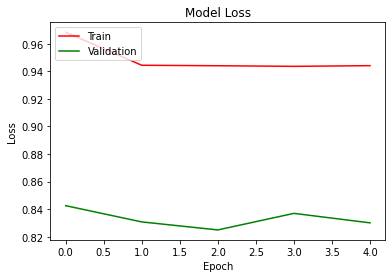

In [ ]:
x = concatenate([i,s,y,m,d])
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([item_in,store_in,year_in,mon_in,day_in], x) 
nn.compile(Adam(0.001), loss='mse')
nn.summary()

history=nn.fit([x_train['i_enc'],x_train['s_enc'],x_train['y_enc'],x_train['m_enc'],x_train['d_enc']], y_train, batch_size=128, epochs=5,
       validation_data = ([x_val['i_enc'],x_val['s_enc'],x_val['y_enc'],x_val['m_enc'],x_val['d_enc']] , y_val ))

plt.plot(figsize=(12,4))
plt.plot(history.history['loss'] , color='red')
plt.plot(history.history['val_loss'] , color='green')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(path+'/pic2.png')
plt.show()


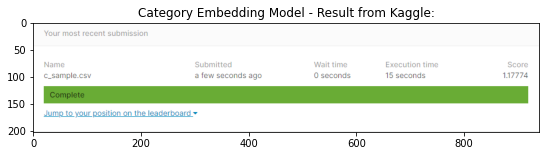

In [4]:
plt.figure(figsize = (20,2))
plt.title("Category Embedding Model - Result from Kaggle:")
plt.imshow(mpimg.imread(path+'/picKaggle/cKAGGLE.PNG'))


## add bias

In [ ]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, embeddings_regularizer=l2(reg))(inp)

def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)


store_in = Input(shape=(1,), dtype='int64', name='store_in')
s = Embedding(n_stores, n_factors, input_length=1, embeddings_regularizer=l2(1e-6))(store_in)

item_in = Input(shape=(1,), dtype='int64', name='item_in')
i = Embedding(n_items,n_factors,input_length=1, embeddings_regularizer=l2(1e-6))(item_in)

year_in = Input(shape=(1,), dtype='int64', name='year_in')
y = Embedding(len(yea_enc),n_factors,input_length=1, embeddings_regularizer=l2(1e-6))(year_in)

mon_in = Input(shape=(1,), dtype='int64', name='mon_in')
m = Embedding(len(mon_enc),n_factors,input_length=1, embeddings_regularizer=l2(1e-6))(mon_in)

day_in = Input(shape=(1,), dtype='int64', name='day_in')
d = Embedding(len(day_enc),n_factors,input_length=1, embeddings_regularizer=l2(1e-6))(day_in)

sb = create_bias(store_in, n_stores)
ib = create_bias(item_in, n_items)
yb = create_bias(year_in, len(yea_enc))
mb = create_bias(mon_in, len(mon_enc))
db = create_bias(day_in, len(day_enc))


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item_in (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
store_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
year_in (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
mon_in (InputLayer)             [(None, 1)]          0                                            
____________________________________________________________________________________________

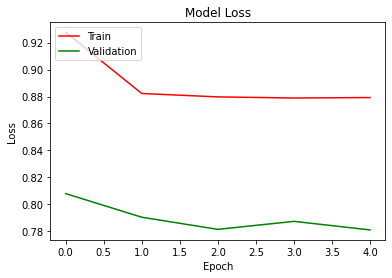

In [ ]:
x = concatenate([i,s,y,m,d])
x = Flatten()(x)
x = add([x, sb])
x = add([x, ib])
x = add([x, yb])
x = add([x, mb])
x = add([x, db])
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn_bias = Model([item_in,store_in,year_in,mon_in,day_in], x) 
nn_bias.compile(Adam(0.001), loss='mse')
nn_bias.summary()

history=nn_bias.fit([x_train['i_enc'],x_train['s_enc'],x_train['y_enc'],x_train['m_enc'],x_train['d_enc']], y_train, batch_size=128, epochs=5,
       validation_data = ([x_val['i_enc'],x_val['s_enc'],x_val['y_enc'],x_val['m_enc'],x_val['d_enc']] , y_val ))

plt.plot(figsize=(12,4))
plt.plot(history.history['loss'] , color='red')
plt.plot(history.history['val_loss'] , color='green')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(path+'/pic2.png')
plt.show()


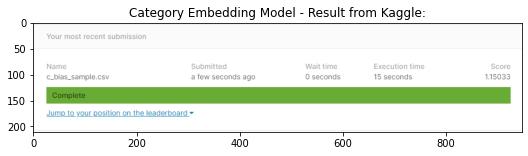

In [5]:
plt.figure(figsize = (20,2))
plt.title("Category Embedding Model - Result from Kaggle:")
plt.imshow(mpimg.imread(path+'/picKaggle/c_bias_kaggle.PNG'))


# Create data set with all the features 


In [ ]:
 train,test,items,stores,oil,holiday,n_items,n_stores=upload_data(3)

## add features

After seeing that our model in the previous section does not reach the solid benchmark value we will try to improve it by adding more features.

We will explain all the features we tried to add:

Let's start first with the features that appear in the given tables:

**From the items table we added the features:**

FAMILY- which represents the type of product (cleaning, care ...)

CLASS - a number that represents the classification of the product group (in more detail)

PERISHABLE- Can the product break down


**From the stores table we have added the features:**

CITY - The city of the store

STATE - The country where the store is located

TYPE - Store type

CLUSTER - Division of the country into clusters


**From the HOLIDAYS table we added the features:**

HOLIDAY - Represents whether it is a holiday or not the specific date

TRANSFER- Represents whether this holiday was celebrated on this day and it is its original day or whether it was postponed as a result of government decisions.


**From the OIL table we added the features:**

dcoilwtico - Represents the price of fuel on the same date


**Beyond the information given in the tables, the explanation in KAGGLE states a number of facts:**

1. The salary distribution takes place on the 1st and 15th of the month, so there are 2 more features - the first is whether it is a salary distribution day and the second is whether it is a day after the salary distribution day.
2. In April 2016 an earthquake occurred that affected the months that followed. Since we decided to choose the DATASET for the months of August we assume that this earthquake did not affect and added noises to our DATA.


As a result of memory problems we could not perform dumy variables for all the features but could be and such a distribution of features could have improved the model.

In [ ]:
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

train,test,items,stores,oil,holiday,n_items,n_stores=upload_data(3)

number_day_of_months={"1": 31, "2": 28, "3": 31, "4": 30, "5": 31, "6": 30, "7": 31, "8": 31, "9": 30
        , "10": 31, "11": 30, "12": 31}

def transform_dataframe(df):
    df['date'] = pd.to_datetime(df['date'])
    df['yea'] = df['date'].dt.year
    df['mon'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['onpromotion'] = df['onpromotion'].map({'False': 0, 'True': 1})
    df['perishable'] = df['perishable'].map({0:1.0, 1:1.25})
    return df

holiday = holiday[holiday['type'] == 'Holiday'][['date','type','locale','locale_name','transferred']]
holiday['date'] = pd.to_datetime(holiday['date'])
train['date'] = pd.to_datetime(train['date'])

print(holiday['date'])
print(train['date'])

train = pd.merge(train, holiday, how='left', on=['date'])
train=reduce_mem_usage(train)
del holiday; gc.collect();

target=train['unit_sales'].values
target[target<0.]=0.
train['unit_sales']=np.log1p(target)
del target; gc.collect();

train = pd.merge(train, items, how='left', on=['item_nbr'])
train=reduce_mem_usage(train)
del items; gc.collect();

train = pd.merge(train, stores, how='left', on=['store_nbr'])
train=reduce_mem_usage(train)
del stores; gc.collect();

train = pd.merge(train, oil, how='left', on=['date'])
train=reduce_mem_usage(train)
del oil; gc.collect();

train=transform_dataframe(train)
train=reduce_mem_usage(train)


train['day after salary day'] = False
train['salary day'] = False
train['transfter_holiday'] = False
train['holiday'] = False
train['earthquake'] = False


for index, row in train.iterrows():
  print(index)
  if row['day']==1 or row['day']==16:
    train['day after salary day'].iloc[[index]]=True
  string=row['mon']
  num=number_day_of_months[str(string)]
  if row['day']==num or row['day']==15:
    train['salary day'].iloc[[index]]=True
  if row['type_x']=='Holiday' and row['transferred']==0:
    train['transfter_holiday'].iloc[[index]]=False
    train['holiday'].iloc[[index]]=True
  elif row['type_x']=='Holiday' and row['transferred']==True:
    train['transfter_holiday'].iloc[[index]]=True
    train['holiday'].iloc[[index]]=False
  elif row['type_x']==np.nan :
    train['transfter_holiday'].iloc[[index]]=False
    train['holiday'].iloc[[index]]=False
  if (row['mon']==4 and row['yea']==2016 and row['day']>15) or (row['mon']==5 and row['yea']==2016 and row['day']<16):
    if row['family'] in family_list:
        train['earthquake'].iloc[[index]]=True

train['onpromotion']=train['onpromotion'].astype(float)
train['onpromotion']=train['onpromotion'].fillna(np.int(-1))
train=reduce_mem_usage(train)

train['dcoilwtico']=train['dcoilwtico'].astype(float)
train['dcoilwtico']=train['dcoilwtico'].fillna(np.int(-1))
train=reduce_mem_usage(train)


train['holiday']=train['holiday'].astype(bool)
train['holiday']=train['holiday'].fillna(False)

train['transfter_holiday']=train['transfter_holiday'].astype(bool)
train['transfter_holiday']=train['transfter_holiday'].fillna(False)

train['transfter_holiday'] = train['transfter_holiday'].map({'False': 0, 'True': 1})
train['holiday'] = train['holiday'].map({'False': 0, 'True': 1})
train=reduce_mem_usage(train)


train

In [ ]:
import pandas as pd
from sklearn.feature_selection import SelectFromModel
from tqdm import tqdm


items_enc = {v:k for (k,v) in enumerate(train['item_nbr'].unique())}
stores_enc = {v:k for (k,v) in enumerate(train['store_nbr'].unique())}
onpromotion_enc = {v:k for (k,v) in enumerate(train['onpromotion'].unique())}
family_enc = {v:k for (k,v) in enumerate(train['family'].unique())}
class_enc = {v:k for (k,v) in enumerate(train['class'].unique())}
city_enc = {v:k for (k,v) in enumerate(train['city'].unique())}
type_enc = {v:k for (k,v) in enumerate(train['type_y'].unique())}
cluster_enc = {v:k for (k,v) in enumerate(train['cluster'].unique())}
dcoilwtico_enc = {v:k for (k,v) in enumerate(train['dcoilwtico'].unique())}
yea_enc = {v:k for (k,v) in enumerate(train['yea'].unique())}
mon_enc = {v:k for (k,v) in enumerate(train['mon'].unique())}
day_enc = {v:k for (k,v) in enumerate(train['day'].unique())}
dayofweek_enc = {v:k for (k,v) in enumerate(train['dayofweek'].unique())}
day_after_salary_day_enc = {v:k for (k,v) in enumerate(train['day after salary day'].unique())}
salary_day_enc = {v:k for (k,v) in enumerate(train['salary day'].unique())}
perishable_enc = {v:k for (k,v) in enumerate(train['perishable'].unique())}
state_enc = {v:k for (k,v) in enumerate(train['state'].unique())}
transfer_enc = {v:k for (k,v) in enumerate(train['transfter_holiday'].unique())}
holiday_enc = {v:k for (k,v) in enumerate(train['holiday'].unique())}
locale_enc = {v:k for (k,v) in enumerate(train['locale'].unique())}

train['i_enc'] = [items_enc[x] for x in train['item_nbr']]
train['s_enc'] = [stores_enc[x] for x in train['store_nbr']]
train['o_enc'] = [onpromotion_enc[x] for x in train['onpromotion']]
train['f_enc'] = [family_enc[x] for x in train['family']]
train['cc_enc'] = [class_enc[x] for x in train['class']]
train['c_enc'] = [city_enc[x] for x in train['city']]
train['t_enc'] = [type_enc[x] for x in train['type_y']]
train['ccc_enc'] = [cluster_enc[x] for x in train['cluster']]
train['d_enc'] = [dcoilwtico_enc[x] for x in train['dcoilwtico']]
train['y_enc'] = [yea_enc[x] for x in train['yea']]
train['m_enc'] = [mon_enc[x] for x in train['mon']]
train['dd_enc'] = [day_enc[x] for x in train['day']]
train['ddd_enc'] = [dayofweek_enc[x] for x in train['dayofweek']]
train['dddd_enc'] = [day_after_salary_day_enc[x] for x in train['day after salary day']]
train['ss_enc'] = [salary_day_enc[x] for x in train['salary day']]
train['p_enc'] = [perishable_enc[x] for x in train['perishable']]
train['sss_enc'] = [state_enc[x] for x in train['state']]
train['tt_enc'] = [transfer_enc[x] for x in train['transfter_holiday']]
train['h_enc'] = [holiday_enc[x] for x in train['holiday']]
train['ll_enc'] = [locale_enc[x] for x in train['locale']]


train=reduce_mem_usage(train)

train_col=['i_enc' , 's_enc','o_enc','f_enc','cc_enc','c_enc','t_enc','ccc_enc','d_enc','y_enc','m_enc','dd_enc'
         'ddd_enc' , 'dddd_enc' , 'ss_enc','p_enc','sss_enc','tt_enc','h_enc', 'll_enc']

train=reduce_mem_usage(train)

train

Decreased by 16.1%
Decreased by 0.0%


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,type_x,locale,locale_name,transferred,family,class,perishable,city,state,type_y,cluster,dcoilwtico,yea,mon,day,dayofweek,day after salary day,salary day,transfter_holiday,holiday,i_enc,s_enc,o_enc,f_enc,cc_enc,c_enc,t_enc,ccc_enc,d_enc,y_enc,m_enc,dd_enc,ddd_enc,dddd_enc,ss_enc,p_enc,sss_enc,ll_enc,tt_enc,h_enc
0,9767476,2013-08-16,1,96995,1.386719,-1.0,NaN,NaN,NaN,NaN,GROCERY I,1093,1.00,Quito,Pichincha,D,13,-1.0,2013,8,16,4,1.0,0.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9767477,2013-08-16,1,103665,1.098633,-1.0,NaN,NaN,NaN,NaN,BREAD/BAKERY,2712,1.25,Quito,Pichincha,D,13,-1.0,2013,8,16,4,1.0,0.0,1.0,1.0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,9767478,2013-08-16,1,105574,1.609375,-1.0,NaN,NaN,NaN,NaN,GROCERY I,1045,1.00,Quito,Pichincha,D,13,-1.0,2013,8,16,4,1.0,0.0,1.0,1.0,2,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9767479,2013-08-16,1,105575,2.484375,-1.0,NaN,NaN,NaN,NaN,GROCERY I,1045,1.00,Quito,Pichincha,D,13,-1.0,2013,8,16,4,1.0,0.0,1.0,1.0,3,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,9767480,2013-08-16,1,105577,1.946289,-1.0,NaN,NaN,NaN,NaN,GROCERY I,1045,1.00,Quito,Pichincha,D,13,-1.0,2013,8,16,4,1.0,0.0,1.0,1.0,4,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4459007,89656772,2016-08-31,54,2026650,1.609375,0.0,NaN,NaN,NaN,NaN,GROCERY I,1034,1.00,El Carmen,Manabi,C,3,-1.0,2016,8,31,2,0.0,1.0,1.0,1.0,3313,46,1,0,12,19,2,7,0,3,0,15,5,1,1,0,14,0,0,0
4459008,89656773,2016-08-31,54,2026801,1.386719,0.0,NaN,NaN,NaN,NaN,GROCERY I,1060,1.00,El Carmen,Manabi,C,3,-1.0,2016,8,31,2,0.0,1.0,1.0,1.0,3314,46,1,0,66,19,2,7,0,3,0,15,5,1,1,0,14,0,0,0
4459009,89656774,2016-08-31,54,2026893,1.386719,0.0,NaN,NaN,NaN,NaN,GROCERY I,1034,1.00,El Carmen,Manabi,C,3,-1.0,2016,8,31,2,0.0,1.0,1.0,1.0,3508,46,1,0,12,19,2,7,0,3,0,15,5,1,1,0,14,0,0,0
4459010,89656775,2016-08-31,54,2026945,1.386719,0.0,NaN,NaN,NaN,NaN,GROCERY I,1034,1.00,El Carmen,Manabi,C,3,-1.0,2016,8,31,2,0.0,1.0,1.0,1.0,3316,46,1,0,12,19,2,7,0,3,0,15,5,1,1,0,14,0,0,0


In [ ]:
train=train.drop(columns=['id','item_nbr','store_nbr','onpromotion','family','class','city','type_x','type_y','cluster','dcoilwtico','yea','mon','day','dayofweek','day after salary day','salary day'
,'perishable','state','transfter_holiday','holiday','locale','locale_name','date','transferred'])
train=reduce_mem_usage(train)
train

Decreased by 0.0%


,date,unit_sales,locale_name,transferred,i_enc,s_enc,o_enc,f_enc,cc_enc,c_enc,t_enc,ccc_enc,d_enc,y_enc,m_enc,dd_enc,ddd_enc,dddd_enc,ss_enc,p_enc,sss_enc,ll_enc,tt_enc,h_enc
0,2013-08-16,1.386719,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2013-08-16,1.098633,NaN,NaN,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2013-08-16,1.609375,NaN,NaN,2,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2013-08-16,2.484375,NaN,NaN,3,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2013-08-16,1.946289,NaN,NaN,4,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4459007,2016-08-31,1.609375,NaN,NaN,3313,46,1,0,12,19,2,7,0,3,0,15,5,1,1,0,14,0,0,0
4459008,2016-08-31,1.386719,NaN,NaN,3314,46,1,0,66,19,2,7,0,3,0,15,5,1,1,0,14,0,0,0
4459009,2016-08-31,1.386719,NaN,NaN,3508,46,1,0,12,19,2,7,0,3,0,15,5,1,1,0,14,0,0,0
4459010,2016-08-31,1.386719,NaN,NaN,3316,46,1,0,12,19,2,7,0,3,0,15,5,1,1,0,14,0,0,0


## fit with all the features

After running the model with all the features it can be seen that the time taken for this model to practice is very long so we would like to see what features are really relevant to our specific data.

**feature selection has been implemented for this purpose**

In [ ]:


items=pd.read_csv(path+'//items.csv')
items=reduce_mem_usage(items)

stores=pd.read_csv(path+'//stores.csv')
stores=reduce_mem_usage(stores)

oil=pd.read_csv(path+'//oil.csv')
oil=reduce_mem_usage(oil)

train['holiday']=train['holiday'].astype(bool)
train['holiday']=train['holiday'].fillna(False)

train['transfter_holiday']=train['transfter_holiday'].astype(bool)
train['transfter_holiday']=train['transfter_holiday'].fillna(False)

train['transfter_holiday'] = train['transfter_holiday'].map({'False': 0, 'True': 1})
train['holiday'] = train['holiday'].map({'False': 0, 'True': 1})
train=reduce_mem_usage(train)

items_enc = {v:k for (k,v) in enumerate(items['item_nbr'].unique())}
stores_enc = {v:k for (k,v) in enumerate(stores['store_nbr'].unique())}
onpromotion_enc = {v:k for (k,v) in enumerate(train['onpromotion'].unique())}
family_enc = {v:k for (k,v) in enumerate(items['family'].unique())}
class_enc = {v:k for (k,v) in enumerate(items['class'].unique())}
city_enc = {v:k for (k,v) in enumerate(stores['city'].unique())}
type_enc = {v:k for (k,v) in enumerate(stores['type'].unique())}
cluster_enc = {v:k for (k,v) in enumerate(stores['cluster'].unique())}
dcoilwtico_enc = {v:k for (k,v) in enumerate(train['dcoilwtico'].unique())}
yea_enc = {v:k for (k,v) in enumerate(train['yea'].unique())}
mon_enc = {v:k for (k,v) in enumerate(train['mon'].unique())}
day_enc = {v:k for (k,v) in enumerate(train['day'].unique())}
dayofweek_enc = {v:k for (k,v) in enumerate(train['dayofweek'].unique())}
day_after_salary_day_enc = {v:k for (k,v) in enumerate(train['day after salary day'].unique())}
salary_day_enc = {v:k for (k,v) in enumerate(train['salary day'].unique())}
perishable_enc = {v:k for (k,v) in enumerate(train['perishable'].unique())}
state_enc = {v:k for (k,v) in enumerate(stores['state'].unique())}
transfer_enc = {v:k for (k,v) in enumerate(train['transfter_holiday'].unique())}
holiday_enc = {v:k for (k,v) in enumerate(train['holiday'].unique())}
locale_enc = {v:k for (k,v) in enumerate(train['locale'].unique())}

train['i_enc'] = [items_enc[x] for x in train['item_nbr']]
train['s_enc'] = [stores_enc[x] for x in train['store_nbr']]
train['o_enc'] = [onpromotion_enc[x] for x in train['onpromotion']]
train['f_enc'] = [family_enc[x] for x in train['family']]
train['cc_enc'] = [class_enc[x] for x in train['class']]
train['c_enc'] = [city_enc[x] for x in train['city']]
train['t_enc'] = [type_enc[x] for x in train['type_y']]
train['ccc_enc'] = [cluster_enc[x] for x in train['cluster']]

train['d_enc'] = [dcoilwtico_enc[x] for x in train['dcoilwtico']]
train['y_enc'] = [yea_enc[x] for x in train['yea']]
train['m_enc'] = [mon_enc[x] for x in train['mon']]
train['dd_enc'] = [day_enc[x] for x in train['day']]
train['ddd_enc'] = [dayofweek_enc[x] for x in train['dayofweek']]
train['dddd_enc'] = [day_after_salary_day_enc[x] for x in train['day after salary day']]
train['ss_enc'] = [salary_day_enc[x] for x in train['salary day']]
train['p_enc'] = [perishable_enc[x] for x in train['perishable']]

train['sss_enc'] = [state_enc[x] for x in train['state']]

#train['tt_enc'] = [transfer_enc[x] for x in train['transfter_holiday']]
#train['h_enc'] = [holiday_enc[x] for x in train['holiday']]
train['ll_enc'] = [locale_enc[x] for x in train['locale']]


train=reduce_mem_usage(train)



n_factors=20

item_in, i = embedding_input('item_in', len(items_enc), n_factors, 1e-4)
store_in, s = embedding_input('store_in', len(stores_enc), n_factors, 1e-4)
onpromotion_in, o = embedding_input('onpromotion_in', len(onpromotion_enc), n_factors, 1e-4)
family_in, f = embedding_input('family_in', len(family_enc), n_factors, 1e-4)
class_in, cc = embedding_input('class_in', len(class_enc), n_factors, 1e-4)
city_in, c = embedding_input('city_in', len(city_enc), n_factors, 1e-4)
type_in, t = embedding_input('type_in', len(type_enc), n_factors, 1e-4)
cluster_in, ccc = embedding_input('cluster_in', len(cluster_enc), n_factors, 1e-4)
dcoilwtico_in, d = embedding_input('dcoilwtico_in', len(dcoilwtico_enc), n_factors, 1e-4)
yea_in, y = embedding_input('yea_in', len(yea_enc), n_factors, 1e-4)
mon_in, m = embedding_input('mon_in', len(mon_enc), n_factors, 1e-4)
day_in, dd = embedding_input('day_in', len(day_enc), n_factors, 1e-4)
dayofweek_in, ddd = embedding_input('dayofweek_in', len(dayofweek_enc), n_factors, 1e-4)
day_after_salary_day_in, dddd = embedding_input('day_after_salary_day_in', len(day_after_salary_day_enc), n_factors, 1e-4)
salary_day_in, ss = embedding_input('salary_day_in', len(salary_day_enc), n_factors, 1e-4)
perishable_in, p = embedding_input('perishable_in', len(perishable_enc), n_factors, 1e-4)
state_in, sss = embedding_input('statee_in', len(state_enc), n_factors, 1e-4)
#transfter_in, tt = embedding_input('transfter_in', len(transfter_enc), n_factors, 1e-4)
#holiday_in, h = embedding_input('holiday_in', len(holiday_enc), n_factors, 1e-4)
locale_in, ll = embedding_input('locale_in', len(locale_enc), n_factors, 1e-4)


train=reduce_mem_usage(train)


train_col=['i_enc' , 's_enc','o_enc','f_enc','cc_enc','c_enc','t_enc','ccc_enc','d_enc','y_enc','m_enc','dd_enc',
         'ddd_enc' , 'dddd_enc' , 'ss_enc','p_enc','sss_enc', 'll_enc']

x_train, x_val , y_train , y_val=train_test_split(train[train_col], train['unit_sales'],test_size=0.2)

x = concatenate([i,s,o,f,cc,c,t,ccc,d,y,m,dd,ddd,dddd,ss,p,sss,ll])
x = Flatten()(x)
x = Dense(200,activation='relu')(x)
x = Dense(100,activation='relu')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(50,activation='relu')(x)
x = Dense(10,activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(1)(x)
nn_model = Model([item_in, store_in,onpromotion_in, family_in,class_in,city_in,type_in,cluster_in,dcoilwtico_in,yea_in,mon_in,day_in,dayofweek_in
                  ,day_after_salary_day_in,salary_day_in,perishable_in,state_in,locale_in],x)
nn_model.compile(Adam(0.001), loss='mse')


start = timeit.default_timer()
history=nn_model.fit([x_train[f] for f in train_col],
             y_train, batch_size=124, epochs=8,callbacks=set_callbacks(description='embedding_all_features'),
             validation_data = ([x_val[f] for f in train_col] , y_val ))
stop = timeit.default_timer()
fit_all_feature_time = stop - start

plt.plot(figsize=(12,4))
plt.plot(history.history['loss'] , color='red')
plt.plot(history.history['val_loss'] , color='green')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(path+'/pic4.png')
plt.show()

Epoch 1/8
66083/66083 [==============================] - 627s 9ms/step - loss: 0.5531 - val_loss: 0.4941

Epoch 00001: val_loss improved from inf to 0.49412, saving model to /content/drive/MyDrive/grocery/best_model_weights_embedding_all_features.h5
Epoch 2/8
66083/66083 [==============================] - 635s 10ms/step - loss: 0.4680 - val_loss: 0.4881

Epoch 00002: val_loss improved from 0.49412 to 0.48809, saving model to /content/drive/MyDrive/grocery/best_model_weights_embedding_all_features.h5
Epoch 3/8
66083/66083 [==============================] - 634s 10ms/step - loss: 0.4656 - val_loss: 0.5019

Epoch 00003: val_loss did not improve from 0.48809
Epoch 4/8
66083/66083 [==============================] - 641s 10ms/step - loss: 0.4644 - val_loss: 0.4908

Epoch 00004: val_loss did not improve from 0.48809
Epoch 5/8
66083/66083 [==============================] - 660s 10ms/step - loss: 0.4638 - val_loss: 0.5040

Epoch 00005: val_loss did not improve from 0.48809
Epoch 6/8
53224/66083

In [ ]:
fit_all_feature_time

5178.021433375001

## feature selection
We will perform feature selection using the random forest regressor machine learning model. 
We will set as input a dataframe that contains all the features we added to the model. By using feature selection we can get the features relevant to our model (ie the model calculates with the help of an optimization function the value of the relevance of the feature to the model and with the help of treshold value the model decides whether the feature is relevant enough to the model and improves it or may even disrupt.)

It seems that the results obtained are 7 features - 

['i_enc', 's_enc', 'cc_enc', 't_enc', 'ccc_enc', 'dd_enc', 'ddd_enc']

**items, stores, class, type, cluster, day and day of week.**

**Some surprising results** -
1. No matter the year, it is a feature that does not affect the model.
2. The assumption was that special days would be very influential like holiday and salary days but it can be seen that they were not considered relevant by the feature selection.
3. The fact whether a product is on sale or not is not relevant to the model - may not affect the amount of purchase of the product.

In [ ]:

train_col=['i_enc' , 's_enc','o_enc','f_enc','cc_enc','c_enc','t_enc','ccc_enc','d_enc','y_enc','m_enc','dd_enc',
         'ddd_enc' , 'dddd_enc' , 'ss_enc','p_enc','sss_enc','tt_enc','h_enc', 'll_enc']


x_train, x_val , y_train , y_val=train_test_split(train[train_col], train['unit_sales'],test_size=0.2)

del train; gc.collect();

x_train=reduce_mem_usage(x_train)
x_val=reduce_mem_usage(x_val)

start = timeit.default_timer()

sel = SelectFromModel(RandomForestRegressor(n_estimators = 15))
print("start fit")
sel.fit(x_train, y_train)
stop = timeit.default_timer()
fit_time_train_xgb = stop - start

print(sel.get_support())
selected_feat= x_train.columns[(sel.get_support())]
print(len(selected_feat))
print(selected_feat)

print("time: "+str(fit_time_train_xgb))

Decreased by 0.0%
Decreased by 0.0%
start fit
[ True  True False False  True False  True  True False False False  True
  True False False False False False False False]
7
Index(['i_enc', 's_enc', 'cc_enc', 't_enc', 'ccc_enc', 'dd_enc', 'ddd_enc'], dtype='object')
time: 568.8287500450024


## fit the model only with the specific features

After running the model only on the 7 features selected in feature selection it seems that we passed the solid benchmark value and even improved.

**After adding the bias we seem to have reached a value of 0.963 in kaggle**

In [ ]:
 train,test,items,stores,oil,holiday,n_items,n_stores=upload_data(3)

In [ ]:
print("number of unique items:" +str(len(items_enc)) )
print("number of unique stores:" +str(len(stores_enc)))
print("number of unique classes:" +str(len(class_enc )))
print("number of unique types:" +str(len(type_enc)))
print("number of unique clusters:" +str(len(cluster_enc)))
print("number of unique days:" +str(len(day_enc)))
print("number of unique days of week:" +str(len(dayofweek_enc)))


number of unique items:4100
number of unique stores:54
number of unique classes:337
number of unique types:5
number of unique clusters:17
number of unique days:31
number of unique days of week:7


In [ ]:
def transform_dataframe(df):
    df['date'] = pd.to_datetime(df['date'])
    df['yea'] = df['date'].dt.year
    df['mon'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['onpromotion'] = df['onpromotion'].map({'False': 0, 'True': 1})
    df['perishable'] = df['perishable'].map({0:1.0, 1:1.25})
    return df

items_enc = {v:k for (k,v) in enumerate(items['item_nbr'].unique())}
stores_enc = {v:k for (k,v) in enumerate(stores['store_nbr'].unique())}
class_enc = {v:k for (k,v) in enumerate(items['class'].unique())}
type_enc = {v:k for (k,v) in enumerate(stores['type'].unique())}
cluster_enc = {v:k for (k,v) in enumerate(stores['cluster'].unique())}


target=train['unit_sales'].values
target[target<0.]=0.
train['unit_sales']=np.log1p(target)
del target; gc.collect();

train = pd.merge(train, items, how='left', on=['item_nbr'])
train=reduce_mem_usage(train)
del items; gc.collect();

train = pd.merge(train, stores, how='left', on=['store_nbr'])
train=reduce_mem_usage(train)
del stores; gc.collect();

train=transform_dataframe(train)
train=reduce_mem_usage(train)

day_enc = {v:k for (k,v) in enumerate(train['day'].unique())}
dayofweek_enc = {v:k for (k,v) in enumerate(train['dayofweek'].unique())}

train['i_enc'] = [items_enc[x] for x in train['item_nbr']]
train['s_enc'] = [stores_enc[x] for x in train['store_nbr']]
train['cc_enc'] = [class_enc[x] for x in train['class']]
train['t_enc'] = [type_enc[x] for x in train['type']]
train['ccc_enc'] = [cluster_enc[x] for x in train['cluster']]
train['dd_enc'] = [day_enc[x] for x in train['day']]
train['ddd_enc'] = [dayofweek_enc[x] for x in train['dayofweek']]

train=train.drop(columns=['id','date','item_nbr','store_nbr','onpromotion','family','class','perishable','city','state','type','cluster','yea','mon','day','dayofweek'])


In [ ]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, embeddings_regularizer=l2(reg))(inp)

def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

n_factors=20

store_in, s = embedding_input('store_in', len(stores_enc), n_factors, 1e-4)
item_in, i = embedding_input('item_in', len(items_enc), n_factors, 1e-4)
class_in, cc = embedding_input('class_in', len(class_enc), n_factors, 1e-4)
type_in, t = embedding_input('type_in', len(type_enc), n_factors, 1e-4)
cluster_in, ccc = embedding_input('cluster_in', len(cluster_enc), n_factors, 1e-4)
day_in, dd = embedding_input('day_in', len(day_enc), n_factors, 1e-4)
dayofweek_in, ddd = embedding_input('dayofweek_in', len(dayofweek_enc), n_factors, 1e-4)

sb = create_bias(store_in, len(stores_enc))
ib = create_bias(item_in, len(items_enc))
ccb = create_bias(class_in, len(class_enc))
tb = create_bias(type_in, len(type_enc))
cccb = create_bias(cluster_in, len(cluster_enc))
ddb = create_bias(day_in, len(day_enc))
dddb = create_bias(dayofweek_in,  len(dayofweek_enc))

In [ ]:
train

,unit_sales,i_enc,s_enc,cc_enc,t_enc,ccc_enc,dd_enc,ddd_enc
0,1.098633,0,0,0,0,0,0,0
1,0.693359,3,0,3,0,0,0,0
2,1.386719,4,0,4,0,0,0,0
3,2.302734,5,0,5,0,0,0,0
4,2.773438,6,0,5,0,0,0,0
...,...,...,...,...,...,...,...,...
10242859,1.609375,3990,53,57,2,7,14,5
10242860,0.693359,3998,53,251,2,7,14,5
10242861,5.261719,4003,53,75,2,7,14,5
10242862,5.292969,4013,53,140,2,7,14,5


In [ ]:
train_col=['i_enc', 's_enc', 'cc_enc', 't_enc', 'ccc_enc', 'dd_enc', 'ddd_enc']

x_train, x_val , y_train , y_val=train_test_split(train[train_col], train['unit_sales'],test_size=0.2)

x_train=reduce_mem_usage(x_train)
x_val=reduce_mem_usage(x_val)

del train; gc.collect();

print("train_shape: "+str(x_train.shape))
print("validation_shape: "+str(x_val.shape))

Decreased by 73.4%
Decreased by 73.4%
train_shape: (8194291, 7)
validation_shape: (2048573, 7)


Epoch 1/8
66083/66083 [==============================] - 425s 6ms/step - loss: 0.5876 - val_loss: 0.4996

Epoch 00001: val_loss improved from inf to 0.49957, saving model to /content/drive/MyDrive/grocery/best_model_weights_embedding.h5
Epoch 2/8
66083/66083 [==============================] - 411s 6ms/step - loss: 0.4839 - val_loss: 0.4984

Epoch 00002: val_loss improved from 0.49957 to 0.49845, saving model to /content/drive/MyDrive/grocery/best_model_weights_embedding.h5
Epoch 3/8
66083/66083 [==============================] - 414s 6ms/step - loss: 0.4674 - val_loss: 0.4868

Epoch 00003: val_loss improved from 0.49845 to 0.48675, saving model to /content/drive/MyDrive/grocery/best_model_weights_embedding.h5
Epoch 4/8
66083/66083 [==============================] - 414s 6ms/step - loss: 0.4659 - val_loss: 0.4907

Epoch 00004: val_loss did not improve from 0.48675
Epoch 5/8
66083/66083 [==============================] - 420s 6ms/step - loss: 0.4644 - val_loss: 0.4849

Epoch 00005: val_l

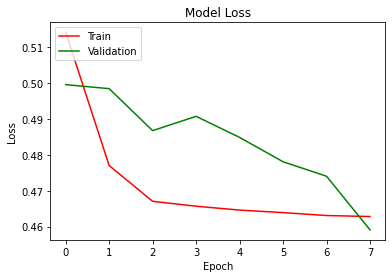

In [ ]:
from tensorflow.keras.layers import *
from sklearn.model_selection import KFold,StratifiedKFold

def set_callbacks(description='run1',patience=15,tb_base_logdir='./logs/'):
    cp =ModelCheckpoint(path+'//best_model_weights_{}.h5'.format(description), monitor='val_loss', 
                            verbose=1, save_best_only=True, mode='min')
    rlop = ReduceLROnPlateau(patience=5)   
    callbacks_list=[cp,rlop]
    return callbacks_list

     
x = concatenate([i,s,cc,t,ccc,dd,ddd])
x = Flatten()(x)
x = Dense(200,activation='relu')(x)
x = Dense(100,activation='relu')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(50,activation='relu')(x)
x = Dense(10,activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(1)(x)
nn_model = Model([item_in, store_in, class_in,type_in, cluster_in,day_in,dayofweek_in],x)
nn_model.compile(Adam(0.001), loss='mse')


start = timeit.default_timer()
history=nn_model.fit([x_train['i_enc'],x_train['s_enc'],x_train['cc_enc'],x_train['t_enc'],x_train['ccc_enc'],x_train['dd_enc'],x_train['ddd_enc']],
             y_train, batch_size=124, epochs=8,callbacks=set_callbacks(description='embedding'),
             validation_data = ([x_val['i_enc'],x_val['s_enc'],x_val['cc_enc'],x_val['t_enc'],x_val['ccc_enc'],x_val['dd_enc'],x_val['ddd_enc']] , y_val ))
stop = timeit.default_timer()
fit_featur_selection_time = stop - start

plt.plot(figsize=(12,4))
plt.plot(history.history['loss'] , color='red')
plt.plot(history.history['val_loss'] , color='green')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(path+'/pic2.png')
plt.show()


In [ ]:
fit_featur_selection_time

3336.482788501

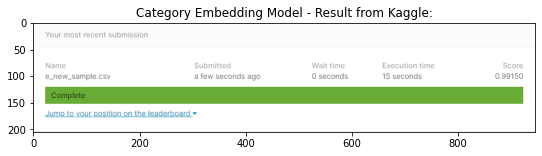

In [8]:
plt.figure(figsize = (20,2))
plt.title("Category Embedding Model - Result from Kaggle:")
plt.imshow(mpimg.imread(path+'/picKaggle/e_new_type.PNG'))

Epoch 1/6
66083/66083 [==============================] - 498s 8ms/step - loss: 0.6177 - val_loss: 0.4410

Epoch 00001: val_loss improved from inf to 0.44098, saving model to /content/drive/MyDrive/grocery/best_model_weights_biasEmbedding.h5
Epoch 2/6
66083/66083 [==============================] - 516s 8ms/step - loss: 0.5016 - val_loss: 0.3949

Epoch 00002: val_loss improved from 0.44098 to 0.39488, saving model to /content/drive/MyDrive/grocery/best_model_weights_biasEmbedding.h5
Epoch 3/6
66083/66083 [==============================] - 530s 8ms/step - loss: 0.4954 - val_loss: 0.4171

Epoch 00003: val_loss did not improve from 0.39488
Epoch 4/6
66083/66083 [==============================] - 506s 8ms/step - loss: 0.4931 - val_loss: 0.4104

Epoch 00004: val_loss did not improve from 0.39488
Epoch 5/6
66083/66083 [==============================] - 499s 8ms/step - loss: 0.4923 - val_loss: 0.4014

Epoch 00005: val_loss did not improve from 0.39488
Epoch 6/6
66083/66083 [====================

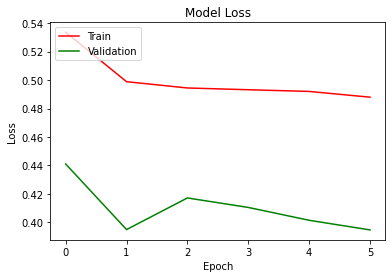

In [ ]:
    
x = concatenate([i,s,cc,t,ccc,dd,ddd])
x = Flatten()(x)
x = add([x, ib])
x = add([x, sb])
x = add([x, ccb])
x = add([x, tb])
x = add([x, cccb])
x = add([x, ddb])
x = add([x, dddb])
x = Dense(200,activation='relu')(x)
x = Dense(100,activation='relu')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(50,activation='relu')(x)
x = Dense(10,activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(1)(x)
nnbias_model = Model([item_in, store_in, class_in,type_in, cluster_in,day_in,dayofweek_in],x)
nnbias_model.compile(Adam(0.001), loss='mse')

start = timeit.default_timer()
history=nnbias_model.fit([x_train['i_enc'],x_train['s_enc'],x_train['cc_enc'],x_train['t_enc'],x_train['ccc_enc'],x_train['dd_enc'],x_train['ddd_enc']],
             y_train, batch_size=124, epochs=6,callbacks=set_callbacks(description='biasEmbedding'),
             validation_data = ([x_val['i_enc'],x_val['s_enc'],x_val['cc_enc'],x_val['t_enc'],x_val['ccc_enc'],x_val['dd_enc'],x_val['ddd_enc']] , y_val ))
stop = timeit.default_timer()
fit_featur_selection_bias_time = stop - start

plt.plot(figsize=(12,4))
plt.plot(history.history['loss'] , color='red')
plt.plot(history.history['val_loss'] , color='green')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(path+'/pic3.png')
plt.show()

In [ ]:
fit_featur_selection_bias_time

3048.6670634620004

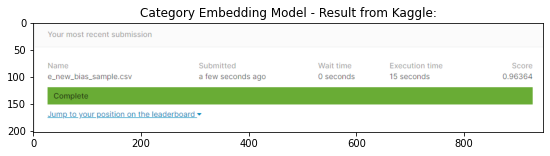

In [9]:
plt.figure(figsize = (20,2))
plt.title("Category Embedding Model - Result from Kaggle:")
plt.imshow(mpimg.imread(path+'/picKaggle/e_bias_new.PNG'))

# Time Series

Beyond the use of category embedding we see that there is a lot of reference to dates during the prediction of the amount of purchase of a product in the store.

As a result, we will try to use a time-based neural network - LSTM.
To use LSTM we will need to convert our data to the appropriate input of a time-based problem.

We will make the date feature to be the index and refer to the 2 features of a product and a store. 
We will try to use our data to predict the test set.

We will now refer to one period backwards, but it may be that looking at more periods backwards will further improve the model.

We will create a dataset for the lstm model and create a dataset for the category embedding model and connect these two models using the concatenate layer.

We connected the lstm model after performing the flatten of the category embedding and not overlapping it, and we will insert the input into the model respectively.

We will look at the results after using both category embedding and lstm. 

**It seems that the loss value we received from kaggle has decreased and now the best value we have reached is 0.958**

From this it can be assumed that our inferences were good and indeed a time-based neural network can help in such a mission.

##lstm model

In [ ]:
datatypes = {'id':'int64', 'item_nbr':'int32', 'store_nbr':'int8', 'onpromotion':str}

data_train=pd.read_csv(path+'//train.csv', dtype=datatypes, parse_dates=['date'])#,skiprows = [i for i in range(1, 125497000)])
data_train=reduce_mem_usage(data_train) 
data_train2 = data_train[(data_train['date'].dt.month == 8)]
del data_train; gc.collect();

train_lstm=data_train2[['date','unit_sales','store_nbr','item_nbr']].copy()

train_lstm['date'] = pd.to_datetime(train_lstm['date'])

train_lstm.set_index('date',inplace=True)

target=train_lstm['unit_sales'].values
target[target<0.]=0.
train_lstm['unit_sales']=np.log2(target+1)
del target; gc.collect();

train_lstm



Decreased by 56.8%


,unit_sales,store_nbr,item_nbr
date,,,
2013-08-01,1.584962,1,96995
2013-08-01,1.000000,1,103520
2013-08-01,2.000000,1,103665
2013-08-01,3.321928,1,105574
2013-08-01,4.000000,1,105575
...,...,...,...
2017-08-15,2.321928,54,2089339
2017-08-15,1.000000,54,2106464
2017-08-15,7.592457,54,2110456


In [ ]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg,n_vars
 
values = train_lstm.values
values = values.astype('float32')
reframed,n_vars = series_to_supervised(values, 1, 1)
reframed.drop(reframed.columns[[0,4,5]], axis=1, inplace=True)
reframed

,var2(t-1),var3(t-1),var1(t)
1,1.0,96995.0,1.000000
2,1.0,103520.0,2.000000
3,1.0,103665.0,3.321928
4,1.0,105574.0,4.000000
5,1.0,105575.0,1.000000
...,...,...,...
10242859,54.0,2089036.0,2.321928
10242860,54.0,2089339.0,1.000000
10242861,54.0,2106464.0,7.592457
10242862,54.0,2110456.0,7.636625


In [ ]:
values = reframed.values
n_train_hours =int(4*(len(reframed))/5)
print(n_train_hours)
train_val = values[:n_train_hours+1, :]
test_val = values[n_train_hours:, :]
# split into input and outputs
train_X_lstm, train_y_lstm = train_val[:, :-1], train_val[:, -1]
test_X_lstm, test_y_lstm = test_val[:, :-1], test_val[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X_lstm = train_X_lstm.reshape((train_X_lstm.shape[0], 1, train_X_lstm.shape[1]))
test_X_lstm = test_X_lstm.reshape((test_X_lstm.shape[0], 1, test_X_lstm.shape[1]))
print(train_X_lstm.shape, train_y_lstm.shape, test_X_lstm.shape, test_y_lstm.shape)

8194290
(8194291, 1, 2) (8194291,) (2048573, 1, 2) (2048573,)


## category embedding model

In [ ]:
 train,test,items,stores,oil,holiday,n_items,n_stores=upload_data(3)

In [ ]:
def transform_dataframe(df):
    df['date'] = pd.to_datetime(df['date'])
    df['yea'] = df['date'].dt.year
    df['mon'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['onpromotion'] = df['onpromotion'].map({'False': 0, 'True': 1})
    df['perishable'] = df['perishable'].map({0:1.0, 1:1.25})
    return df

items_enc = {v:k for (k,v) in enumerate(items['item_nbr'].unique())}
stores_enc = {v:k for (k,v) in enumerate(stores['store_nbr'].unique())}
class_enc = {v:k for (k,v) in enumerate(items['class'].unique())}
type_enc = {v:k for (k,v) in enumerate(stores['type'].unique())}
cluster_enc = {v:k for (k,v) in enumerate(stores['cluster'].unique())}


target=train['unit_sales'].values
target[target<0.]=0.
train['unit_sales']=np.log1p(target)
del target; gc.collect();

train = pd.merge(train, items, how='left', on=['item_nbr'])
train=reduce_mem_usage(train)
del items; gc.collect();

train = pd.merge(train, stores, how='left', on=['store_nbr'])
train=reduce_mem_usage(train)
del stores; gc.collect();

train=transform_dataframe(train)
train=reduce_mem_usage(train)

day_enc = {v:k for (k,v) in enumerate(train['day'].unique())}
dayofweek_enc = {v:k for (k,v) in enumerate(train['dayofweek'].unique())}

train['i_enc'] = [items_enc[x] for x in train['item_nbr']]
train['s_enc'] = [stores_enc[x] for x in train['store_nbr']]
train['cc_enc'] = [class_enc[x] for x in train['class']]
train['t_enc'] = [type_enc[x] for x in train['type']]
train['ccc_enc'] = [cluster_enc[x] for x in train['cluster']]
train['dd_enc'] = [day_enc[x] for x in train['day']]
train['ddd_enc'] = [dayofweek_enc[x] for x in train['dayofweek']]

train=train.drop(columns=['id','date','item_nbr','store_nbr','onpromotion','family','class','perishable','city','state','type','cluster','yea','mon','day','dayofweek'])

def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, embeddings_regularizer=l2(reg))(inp)

def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)


In [ ]:

n_factors=20

item_in, i = embedding_input('item_in', len(items_enc), 50, 1e-4)
store_in, s = embedding_input('store_in', len(stores_enc), 50, 1e-4)
class_in, cc = embedding_input('class_in', len(class_enc), 50, 1e-4)
type_in, t = embedding_input('type_in', len(type_enc), 10, 1e-4)
cluster_in, ccc = embedding_input('cluster_in', len(cluster_enc), 10, 1e-4)
day_in, dd = embedding_input('day_in', len(day_enc), 10, 1e-4)
dayofweek_in, ddd = embedding_input('dayofweek_in', len(dayofweek_enc), 10, 1e-4)

sb = create_bias(store_in, len(stores_enc))
ib = create_bias(item_in, len(items_enc))
ccb = create_bias(class_in, len(class_enc))
tb = create_bias(type_in, len(type_enc))
cccb = create_bias(cluster_in, len(cluster_enc))
ddb = create_bias(day_in, len(day_enc))
dddb = create_bias(dayofweek_in,  len(dayofweek_enc))

train_col=['i_enc', 's_enc', 'cc_enc', 't_enc', 'ccc_enc', 'dd_enc', 'ddd_enc']

x_train, x_val , y_train , y_val=train_test_split(train[train_col], train['unit_sales'],test_size=0.2)

x_train=reduce_mem_usage(x_train)
x_val=reduce_mem_usage(x_val)

del train; gc.collect();

## model

In [ ]:
lstm_input = Input(shape=(1,2),)
ls= LSTM(6)(lstm_input)

x = concatenate([i,s,cc,t,ccc,dd,ddd])
x = Flatten()(x)
x = add([x, ib])
x = add([x, sb])
x = add([x, ccb])
x = add([x, tb])
x = add([x, cccb])
x = add([x, ddb])
x = add([x, dddb])
x=concatenate([ls,x])
x = Dense(200,activation='relu')(x)
x = Dense(100,activation='relu')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(50,activation='relu')(x)
x = Dense(10,activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(1)(x)
nnbias_model = Model([lstm_input,item_in, store_in, class_in,type_in, cluster_in,day_in,dayofweek_in],x)
nnbias_model.compile(Adam(0.001), loss='mse')


start = timeit.default_timer()
history=nnbias_model.fit([train_X_lstm,x_train['i_enc'],x_train['s_enc'],x_train['cc_enc'],x_train['t_enc'],x_train['ccc_enc'],x_train['dd_enc'],x_train['ddd_enc']],
             y_train, batch_size=124, epochs=6,callbacks=set_callbacks(description='lstm'),
             validation_data = ([test_X_lstm,x_val['i_enc'],x_val['s_enc'],x_val['cc_enc'],x_val['t_enc'],x_val['ccc_enc'],x_val['dd_enc'],x_val['ddd_enc']] , y_val ))
stop = timeit.default_timer()
fit_featur_selection_bias_time = stop - start

plt.plot(figsize=(12,4))
plt.plot(history.history['loss'] , color='red')
plt.plot(history.history['val_loss'] , color='green')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(path+'/pic3.png')
plt.show()

Epoch 1/6
66083/66083 [==============================] - 643s 10ms/step - loss: 0.6067 - val_loss: 0.4073

Epoch 00001: val_loss improved from inf to 0.40733, saving model to /content/drive/MyDrive/grocery/best_model_weights_lstm.h5
Epoch 2/6
66083/66083 [==============================] - 642s 10ms/step - loss: 0.4873 - val_loss: 0.4032

Epoch 00002: val_loss improved from 0.40733 to 0.40317, saving model to /content/drive/MyDrive/grocery/best_model_weights_lstm.h5
Epoch 3/6
66083/66083 [==============================] - 656s 10ms/step - loss: 0.4774 - val_loss: 0.4051

Epoch 00003: val_loss did not improve from 0.40317
Epoch 4/6
66083/66083 [==============================] - 650s 10ms/step - loss: 0.4754 - val_loss: 0.4064

Epoch 00004: val_loss did not improve from 0.40317
Epoch 5/6
66083/66083 [==============================] - 655s 10ms/step - loss: 0.4741 - val_loss: 0.3994

Epoch 00005: val_loss improved from 0.40317 to 0.39943, saving model to /content/drive/MyDrive/grocery/best

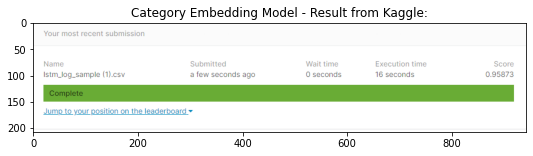

In [11]:
plt.figure(figsize = (20,2))
plt.title("Category Embedding Model - Result from Kaggle:")
plt.imshow(mpimg.imread(path+'/picKaggle/lstm.PNG'))

# Some interesting insights and conclusion

After reaching a value of 0.958 we will summarize all our conclusions:

1. If we increase the amount of time periods we look back we may get better values.

2. Interesting results regarding the selected features:
   

*    No matter the year, it is a feature that does not affect the model.
*   The assumption was that special days would be very influential like holiday and salary days but it can be seen that they were not considered relevant by the feature selection.
*   The fact whether a product is on sale or not is not relevant to the model - may not affect the amount of purchase of the product.


3. The bias value is important in our model, it helps to clean noises of certain data and fit the results.

# feature extractor
In this model we will take the model from section E and perform a feature extractor on it in order to try to see if removing the last layer and take out the features and running them on a classic machine learning model will improve the results.

in our mission we choose the classic machine learning as Random Forest Regressor.

To implement the feature extractor we will take the previous model and remove from it the last layer that performs the regression prediction to the value of the sales count.

We will get a layer with 10 neurons and make a prediction on it.

**The results obtained in kaggle appear to be loss values ​​higher than the values ​​obtained in Section E.**

In this section we perform a feature extractor with a very small amount of features (total 10). We assume that if we increase the complexity of the model and perform a feature extractor on a more complex model the results will be better, the loss value will be lower and maybe even lower than the value In section E.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn import metrics

nn_model=read_model("e_bias_new_done")

train_col=['i_enc', 's_enc', 'cc_enc', 't_enc', 'ccc_enc', 'dd_enc', 'ddd_enc']

for_predict=x_train[train_col].copy()

features = for_predict.columns

model_new = Model(nn_model.input, nn_model.layers[-2].output)
model_new.summary()

start = timeit.default_timer()
print("Start predict train")
predictions_train = model_new.predict([for_predict[f] for f in features] , batch_size=32)
stop = timeit.default_timer()
predict_time_train = stop - start

for_predict=x_val[train_col].copy()

print("Start predict Validation")
start = timeit.default_timer()
predictions_validation = model_new.predict([for_predict[f] for f in features] , batch_size=32)
stop = timeit.default_timer()
predict_time_val = stop - start

rfr = RandomForestRegressor(n_estimators=5, max_depth = 3, n_jobs = -1, criterion='mse')

start = timeit.default_timer()
rfr.fit(predictions_train , np.array(y_train))
stop = timeit.default_timer()
fit_time_rft = stop - start


start = timeit.default_timer()
predictions_rfr = rfr.predict(predictions_validation)
stop = timeit.default_timer()
predict_time_rfr = stop - start






Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item_in (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
store_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
class_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
type_in (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

In [ ]:
lrc_val_msle = metrics.mean_squared_error(y_val,predictions_rfr)**0.5
print(lrc_val_msle)

0.6755133243163274


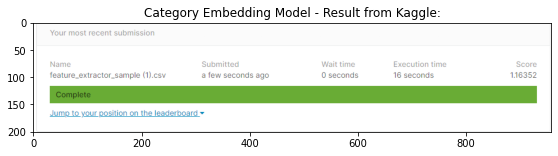

In [10]:
plt.figure(figsize = (20,2))
plt.title("Category Embedding Model - Result from Kaggle:")
plt.imshow(mpimg.imread(path+'/picKaggle/feature extractor kaggle.PNG'))

#  sample submission

Production of the file for submission to kaggle and display the test set

In [ ]:
test

,id,date,store_nbr,item_nbr,onpromotion,family,class,perishable,city,state,type,cluster,yea,mon,day,dayofweek
0,125497040,2017-08-16,1,96995,False,GROCERY I,1093,0,Quito,Pichincha,D,13,2017,8,16,2
1,125497041,2017-08-16,1,99197,False,GROCERY I,1067,0,Quito,Pichincha,D,13,2017,8,16,2
2,125497042,2017-08-16,1,103501,False,CLEANING,3008,0,Quito,Pichincha,D,13,2017,8,16,2
3,125497043,2017-08-16,1,103520,False,GROCERY I,1028,0,Quito,Pichincha,D,13,2017,8,16,2
4,125497044,2017-08-16,1,103665,False,BREAD/BAKERY,2712,1,Quito,Pichincha,D,13,2017,8,16,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370459,128867499,2017-08-31,54,2132163,False,GROCERY I,1040,0,El Carmen,Manabi,C,3,2017,8,31,3
3370460,128867500,2017-08-31,54,2132318,False,GROCERY I,1002,0,El Carmen,Manabi,C,3,2017,8,31,3
3370461,128867501,2017-08-31,54,2132945,False,GROCERY I,1026,0,El Carmen,Manabi,C,3,2017,8,31,3
3370462,128867502,2017-08-31,54,2132957,False,GROCERY I,1068,0,El Carmen,Manabi,C,3,2017,8,31,3


## for c

In [ ]:
import csv

datatypes = {'id':'int64', 'item_nbr':'int32', 'store_nbr':'int8', 'onpromotion':str}
test=pd.read_csv(path+'//test.csv', dtype=datatypes, parse_dates=['date'])
test=reduce_mem_usage(test)

id=test['id']

data_items=pd.read_csv(path+'//items.csv')
data_items=reduce_mem_usage(data_items)
n_items=data_items.shape[0]

data_stores=pd.read_csv(path+'//stores.csv')
data_stores=reduce_mem_usage(data_stores)
n_stores=data_stores.shape[0]

def transform_dataframe(df):
    df['date'] = pd.to_datetime(df['date'])
    df['yea'] = df['date'].dt.year
    df['mon'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['onpromotion'] = df['onpromotion'].map({'False': 0, 'True': 1})
    df['perishable'] = df['perishable'].map({0:1.0, 1:1.25})

    return df

test = pd.merge(test, data_items, how='left', on=['item_nbr'])
test=reduce_mem_usage(test)

test = pd.merge(test, data_stores, how='left', on=['store_nbr'])
test=reduce_mem_usage(test)

test = pd.merge(test, data_oil, how='left', on=['date'])
test=reduce_mem_usage(test)

test=transform_dataframe(test)
test=reduce_mem_usage(test)

test['i_enc'] = [items_enc[x] for x in test['item_nbr']]
test['s_enc'] = [stores_enc[x] for x in test['store_nbr']]
test['y_enc'] = [yea_enc[x] for x in test['yea']]
test['m_enc'] = [mon_enc[x] for x in test['mon']]
test['dd_enc'] = [day_enc[x] for x in test['day']]

train_col=['i_enc', 's_enc', 'y_enc', 'm_enc', 'dd_enc']

for_predict=test[train_col].copy()
del test; gc.collect();

features = for_predict.columns

preds = nn_bias.predict([for_predict[f] for f in features])


dataset = pd.DataFrame(id)
dataset['unit_sales']=pd.DataFrame(preds)
dataset['unit_sales']=pow(2,dataset['unit_sales'])-1

dataset.to_csv(path+'//c_sample.csv', index=False)



## for e

In [ ]:

datatypes = {'id':'int64', 'item_nbr':'int32', 'store_nbr':'int8', 'onpromotion':str}
test=pd.read_csv(path+'//test.csv', dtype=datatypes, parse_dates=['date'])
test=reduce_mem_usage(test)

id=test['id']

data_items=pd.read_csv(path+'//items.csv')
data_items=reduce_mem_usage(data_items)
n_items=data_items.shape[0]

data_stores=pd.read_csv(path+'//stores.csv')
data_stores=reduce_mem_usage(data_stores)
n_stores=data_stores.shape[0]

data_oil=pd.read_csv(path+'//oil.csv')
data_oil=reduce_mem_usage(data_oil)
          


items_enc = {v:k for (k,v) in enumerate(data_items['item_nbr'].unique())}
stores_enc = {v:k for (k,v) in enumerate(data_stores['store_nbr'].unique())}
class_enc = {v:k for (k,v) in enumerate(data_items['class'].unique())}
type_enc = {v:k for (k,v) in enumerate(data_stores['type'].unique())}
cluster_enc = {v:k for (k,v) in enumerate(data_stores['cluster'].unique())}


def transform_dataframe(df):
    df['date'] = pd.to_datetime(df['date'])
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['onpromotion'] = df['onpromotion'].map({'False': 0, 'True': 1})
    df['perishable'] = df['perishable'].map({0:1.0, 1:1.25})

    return df




test = pd.merge(test, data_items, how='left', on=['item_nbr'])
test=reduce_mem_usage(test)

test = pd.merge(test, data_stores, how='left', on=['store_nbr'])
test=reduce_mem_usage(test)

test = pd.merge(test, data_oil, how='left', on=['date'])
test=reduce_mem_usage(test)

test=transform_dataframe(test)
test=reduce_mem_usage(test)


test['onpromotion']=test['onpromotion'].astype(float)
test['onpromotion']=test['onpromotion'].fillna(np.int(-1))
test=reduce_mem_usage(test)

test['i_enc'] = [items_enc[x] for x in test['item_nbr']]
test['s_enc'] = [stores_enc[x] for x in test['store_nbr']]
test['cc_enc'] = [class_enc[x] for x in test['class']]
test['t_enc'] = [type_enc[x] for x in test['type']]
test['ccc_enc'] = [cluster_enc[x] for x in test['cluster']]
test['dd_enc'] = [day_enc[x] for x in test['day']]
test['ddd_enc'] = [dayofweek_enc[x] for x in test['dayofweek']]


train_col=['i_enc', 's_enc', 'cc_enc', 't_enc', 'ccc_enc', 'dd_enc', 'ddd_enc']

for_predict=test[train_col].copy()
del test; gc.collect();


features = for_predict.columns

preds = nn_model.predict([for_predict['i_enc'],for_predict['s_enc'], for_predict['cc_enc'],for_predict['t_enc'], for_predict['ccc_enc'],for_predict['dd_enc'], for_predict['ddd_enc']])

dataset = pd.DataFrame(id)
dataset['unit_sales']=pd.DataFrame(preds)
dataset['unit_sales']=pow(2,dataset['unit_sales'])-1

dataset.to_csv(path+'//e_sample.csv', index=False)


# CONCLUSION 



In this mission we implement Category Embedding in order to predict the amount of product purchase in a particular store in the last two weeks of August 2017.

The first question we deal with was which data to use. We received a very large training file (125 million records) and we need to see which information gives the best loss values ​​on the two weeks required for prediction.

After we have chosen the data that we will work with the second question was what are the most important features for data that they can predict most accurately.
After running the model on all the features we chose (all the information we got from the kaggle tables) we saw that beyond that it could cause overfitting on the training set, the running time is very high so we decided to use feature selection to check what features are most relevant to our model.

We got that the really relevant features were similar to our inferences at first (according to the graphs we got), we ran the model with these features and saw that we passed the solid benchmark value from the kaggle results.
In addition to the model we added bias to deal with the noises and incorrect learning of the model.

Finally, we decided to add a reference to the time series problem of our information. As you can see we are talking about dates so we assumed that the sequence of dates can have an effect on the model results.
To address this problem we implemented an LSTM time-based neural network and  we saw that it improved the prediction results of the model in kaggle.

There are many other ways to use the time problem to improve our model like lag features that will consider mean, median and common values ​​for values ​​in a certain sequence of days but we decided to implement the LSTM time-based neural network instead.

In addition, another way that could possibly be an improvement (maybe a small one) is to perform a number of experiments on the optimal n factor for our model and embedding regularization.

Finally, we took the model we got after adding the features and wanted to test if implement feature extractor would perform the prediction more accurately (and perhaps even faster). It can be seen that because the number of features is small the loss values ​​we got are relatively high values. We will conclude that if we increase the number of features we will get better values.

In conclusion, the work was very interesting, and the combination of reference between features and time sequences was challenging.